# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import math
import os

torch.set_float32_matmul_precision('medium')

# Architecture

In [2]:
class NanoLILY(nn.Module):
    def __init__(self):
        super(NanoLILY, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.final_spatial = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        self.freq_mask = nn.Parameter(torch.full((1, 3, 224, 113), 0.01))

        self.fusion = nn.Sequential(
            nn.Conv2d(6, 3, kernel_size=1),
            nn.Tanh() # Constrains the residual to a stable range [-1, 1]
        )

    def forward(self, x):
        identity = x

        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        up1 = self.dec1(s2)
        spatial_out = self.final_spatial(up1 + s1) 


        x_fft = torch.fft.rfft2(x)
        x_fft_filtered = x_fft * self.freq_mask
        freq_out = torch.fft.irfft2(x_fft_filtered, s=(224, 224))

        combined = torch.cat([spatial_out, freq_out], dim=1)
        residual = self.fusion(combined)

        return identity + residual

# The training system (The Brain)

In [3]:
class NanoLILYSystem(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
   
        
    def forward(self, x):
        return self.model(x)

# Demo Cell

In [4]:
def run_lily_demo(checkpoint_path, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Initializing LILY Bloom Engine on: {device}...")
    

    base_model = NanoLILY() 
    model = NanoLILYSystem.load_from_checkpoint(checkpoint_path, model=base_model, strict=False)
    model.to(device)
    model.eval()


    img_pil = Image.open(image_path).convert("RGB")
    w, h = img_pil.size
    img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(device)


    with torch.no_grad():
        core_input = F.interpolate(img_tensor, size=(224, 224), mode='bilinear', align_corners=False)
        core_raw = model(core_input)
        core_out = F.interpolate(core_raw, size=(h, w), mode='bilinear', align_corners=False)
        core_np = torch.clamp(core_out.squeeze(0).cpu(), 0, 1).permute(1, 2, 0).numpy()


    patch_size, stride = 224, 112
    pad_h = (math.ceil((h - patch_size) / stride) * stride + patch_size) - h
    pad_w = (math.ceil((w - patch_size) / stride) * stride + patch_size) - w
    padded = F.pad(img_tensor, (0, pad_w, 0, pad_h), mode='reflect')
    
    win = torch.hann_window(patch_size, device=device)
    win_2d = (win.unsqueeze(0) * win.unsqueeze(1)).expand(1, 3, patch_size, patch_size)
    
    canvas = torch.zeros_like(padded)
    weight = torch.zeros_like(padded)
    
    with torch.no_grad():
        for y in range(0, padded.shape[2] - patch_size + 1, stride):
            for x in range(0, padded.shape[3] - patch_size + 1, stride):
                p = padded[:, :, y:y+patch_size, x:x+patch_size]
                out_p = model(p)
                canvas[:, :, y:y+patch_size, x:x+patch_size] += out_p * win_2d
                weight[:, :, y:y+patch_size, x:x+patch_size] += win_2d
                
    engine_out = (canvas / (weight + 1e-8))[:, :, :h, :w]
    engine_np = torch.clamp(engine_out.squeeze(0).cpu(), 0, 1).permute(1, 2, 0).numpy()
    
 
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    input_np = np.array(img_pil) / 255.0
    
    axes[0].imshow(input_np)
    axes[0].set_title(f"1. Raw Input\n({w}x{h})", fontsize=14)
    
    axes[1].imshow(core_np)
    axes[1].set_title("2. NanoLILY Core Output\n(Low-Resolution Processing)", fontsize=14)
    
    axes[2].imshow(engine_np)
    axes[2].set_title("3. LILY Bloom Engine Output\n(Seamless High-Resolution)", fontsize=14)
    
    for ax in axes: ax.axis('off')
    plt.subplots_adjust(wspace=0.02)
    plt.show()

## User control panel

🚀 Initializing LILY Bloom Engine on: cuda...


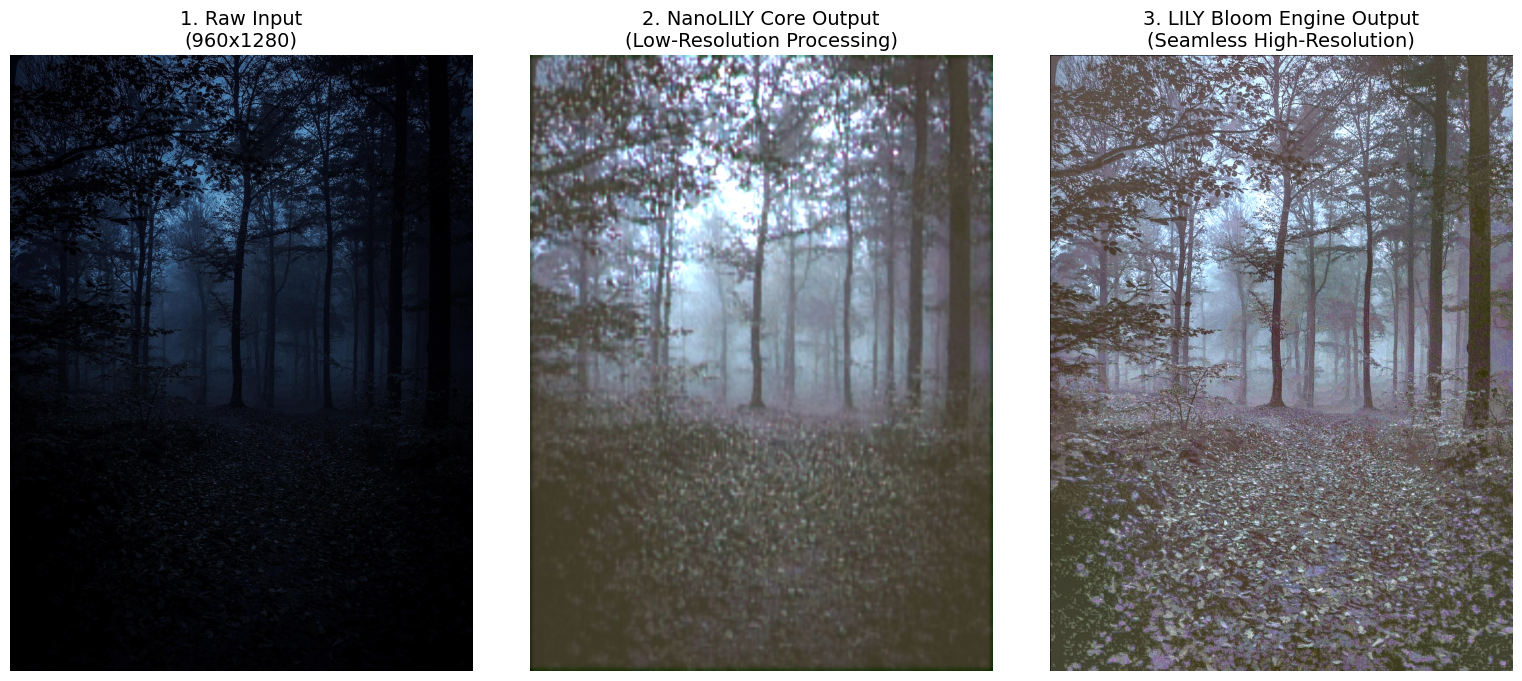

In [ ]:
# =====================================================================
# 🎛️ USER CONTROL PANEL
# Enter the path to your dark image here!
# =====================================================================

# Note: Download the .ckpt weights from the Kaggle link in the README first!
CHECKPOINT_PATH = "../models/NanoLILY"
USER_IMAGE_PATH = "../test images/forest-7543646_1280.jpg" 

run_lily_demo(CHECKPOINT_PATH, USER_IMAGE_PATH)